In [1]:
#####Import and Define Functions#####

import numpy as np
from io import open
import glob
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt


import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.utils.data as data_utils


import os
import re


import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

from sklearn.preprocessing import LabelEncoder


# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
def prints(matrix): 
    return print("-----",namestr(matrix,globals()),":",matrix.shape, ":", type(matrix),"-----\n")
def printd(matrix): 
    return print("-----",namestr(matrix,globals()),":",matrix.shape, ":", type(matrix),"-----\n",pd.DataFrame(matrix).head(5))

def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum(xi*yi for xi,yi in zip(X, Y)) - n * xbar * ybar
    denum = sum(xi**2 for xi in X) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

    return a, b



Using TensorFlow backend.


In [2]:
##### Import Files #####

allFiles = glob.glob('/Users/mdclark/Dropbox/AVEC17/data/selfDisclosure/*[0-9].csv')

#Create Data Frame
all_data_frames = []
for file in allFiles: 
    data_frame = pd.read_csv(file, index_col=None)
    all_data_frames.append(data_frame)
df = pd.concat(all_data_frames, axis=0, ignore_index=True)


#See what shuffling the rows does
df = df.sample(frac=1).reset_index(drop=True)


df = df.as_matrix()



#Inputs
X = df[:,2:]
prints(X)
#Ratings
ratings_cont = df[:,1]
prints(ratings_cont)



----- ['X'] : (2551, 242) : <class 'numpy.ndarray'> -----

----- ['ratings_cont'] : (2551,) : <class 'numpy.ndarray'> -----



In [3]:
##### Categorize Ratings into Low/Med/High and Dummy Code Them  #####


def Categorize(rating): 
    if rating > 50:
        return 3
    elif rating == 50:
        return 2
    elif rating < 50:
        return 1
    else:
        print("error")
        
classes = [0, 1, 2]

ratings_cat = np.array([Categorize(rating) for rating in ratings_cont])

#Creates on-hot vector
#encoder = LabelEncoder()
#encoder.fit(ratings_cat)
#encoded_Y = encoder.transform(ratings_cat)
# convert integers to dummy variables (i.e. one hot encoded) ****
#dummy_y = np_utils.to_categorical(encoded_Y).astype(int)



#Vector of Class Indices
dummy_y = ratings_cat.astype(int).T


In [2]:
plt.hist(dummy_y, bins=1)
plt.show()

NameError: name 'plt' is not defined

In [5]:
#https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/01-basics/feedforward_neural_network/main.py



# Hyper Parameters - Desmond's Data
input_size = 242
hidden_size = 50
num_classes = 4
num_epochs = 200
batch_size = 20
learning_rate = 0.001


#https://github.com/kimhc6028/pathnet-pytorch/blob/master/cifar_dataset.py

#Subset into Training and Test Data
trainingnum = 2000

X_train = X[0:trainingnum,: ]
dummy_y_train = dummy_y[0:trainingnum ]

X_test = X[trainingnum:2550,: ]
dummy_y_test = dummy_y[trainingnum:2550 ]

prints(X_train)
prints(X_test)
prints(dummy_y_train)
prints(dummy_y_test)


tensor_data_train = torch.from_numpy(X_train)
tensor_data_train = tensor_data_train.float()
tensor_target_train = torch.from_numpy(dummy_y_train)

tensor_data_test = torch.from_numpy(X_test)
tensor_data_test = tensor_data_test.float()
tensor_target_test = torch.from_numpy(dummy_y_test)

#Create Data Loader from Training and test data
train_dataset = data_utils.TensorDataset(tensor_data_train, tensor_target_train)
train_loader = data_utils.DataLoader(train_dataset, batch_size=batch_size, shuffle = True)

test_dataset = data_utils.TensorDataset(tensor_data_test, tensor_target_test)
test_loader = data_utils.DataLoader(test_dataset, batch_size=batch_size, shuffle = True)


#test = train = data_utils.TensorDataset(torch.FloatTensor(X), torch.LongTensor(dummy_y))
#test_loader = data_utils.DataLoader(train, batch_size=50, shuffle=True)



----- ['X_train'] : (2000, 242) : <class 'numpy.ndarray'> -----

----- ['X_test'] : (550, 242) : <class 'numpy.ndarray'> -----

----- ['dummy_y_train'] : (2000,) : <class 'numpy.ndarray'> -----

----- ['dummy_y_test'] : (550,) : <class 'numpy.ndarray'> -----



In [6]:
# Neural Network Model (1 hidden layer)
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, int(hidden_size/2))
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(int(hidden_size/2), int(hidden_size/5),)
        self.relu3 = nn.Sigmoid()
        self.fc4 = nn.Linear(int(hidden_size/5), num_classes,)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)

        return out
    
net = Net(input_size, hidden_size, num_classes)

    
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  


In [7]:
# Train the Model
all_losses = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Convert torch tensor to Variable
        images = Variable(images)
        labels = Variable(labels)
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
            all_losses.append(loss.data[0] )
            current_loss = 0



Epoch [1/200], Step [100/100], Loss: 1.4097
Epoch [2/200], Step [100/100], Loss: 1.1412
Epoch [3/200], Step [100/100], Loss: 1.0740
Epoch [4/200], Step [100/100], Loss: 1.2259
Epoch [5/200], Step [100/100], Loss: 0.9221
Epoch [6/200], Step [100/100], Loss: 1.0028
Epoch [7/200], Step [100/100], Loss: 1.1309
Epoch [8/200], Step [100/100], Loss: 0.8855
Epoch [9/200], Step [100/100], Loss: 0.8418
Epoch [10/200], Step [100/100], Loss: 1.0090
Epoch [11/200], Step [100/100], Loss: 0.9750
Epoch [12/200], Step [100/100], Loss: 1.1404
Epoch [13/200], Step [100/100], Loss: 1.0620
Epoch [14/200], Step [100/100], Loss: 1.0018
Epoch [15/200], Step [100/100], Loss: 1.0563
Epoch [16/200], Step [100/100], Loss: 0.8434
Epoch [17/200], Step [100/100], Loss: 1.0298
Epoch [18/200], Step [100/100], Loss: 0.7820
Epoch [19/200], Step [100/100], Loss: 0.7515
Epoch [20/200], Step [100/100], Loss: 0.5619
Epoch [21/200], Step [100/100], Loss: 0.9953
Epoch [22/200], Step [100/100], Loss: 0.8143
Epoch [23/200], Ste

In [8]:
# Test the Model
correct = 0
total = 0

predicted_all = []
labels_all = []


for images, labels in test_loader:
    images = Variable(images)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    labels_all = np.append(labels_all, labels.numpy())
    predicted_all = np.append(predicted_all, predicted.numpy().T[0])



print('Accuracy of the network on the test items: %d %%' % (100 * correct / total))

# Save the Model
torch.save(net.state_dict(), 'model.pkl')

Accuracy of the network on the test items: 61 %


Accuracy of the network on the test items: 61 %


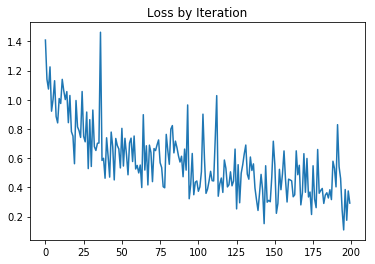

best fit line:
y = 1.15 + 0.35x


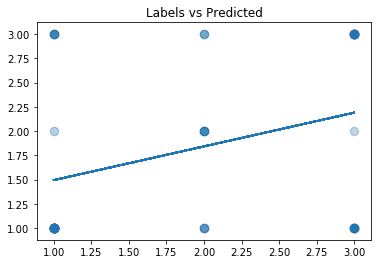

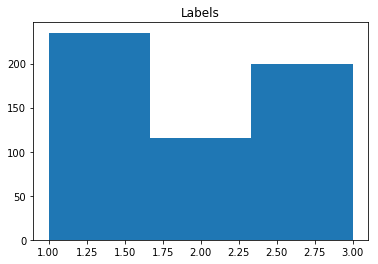

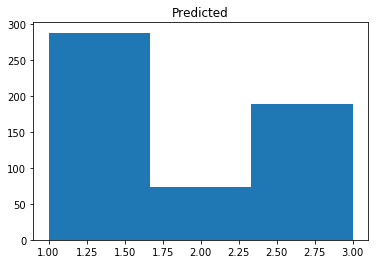

In [9]:
#http://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html#evaluating-the-results
print('Accuracy of the network on the test items: %d %%' % (100 * correct / total))

plt.figure()
plt.plot(all_losses)
plt.title('Loss by Iteration')
plt.show()


a, b = best_fit(labels_all, predicted_all)
plt.scatter(labels_all, predicted_all, s=70, alpha=0.03)
yfit = [a + b * xi for xi in labels_all]
plt.plot(labels_all, yfit)
plt.title('Labels vs Predicted')
plt.show()

plt.hist(labels_all, bins=3)
plt.title('Labels')
plt.show()

plt.hist(predicted_all, bins=3)
plt.title('Predicted')
plt.show()

In [ ]:
def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum(xi*yi for xi,yi in zip(X, Y)) - n * xbar * ybar
    denum = sum(xi**2 for xi in X) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

    return a, b


## Using Keras and Kfold Validation

In [ ]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(242, input_dim=242, activation='relu')) #Dense(n) = how many hidden layers
    model.add(Dense(100, input_dim=242, activation='relu')) #Dense(n) = how many hidden layers
    model.add(Dense(50, input_dim=242, activation='relu')) #Dense(n) = how many hidden layers
    model.add(Dense(3, activation='softmax')) #3 Outputs
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=50, batch_size=30, verbose=0)

In [ ]:
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [ ]:
results = cross_val_score(estimator, X, dummy_y, cv=kfold)
#print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

## Using Keras (even older - validation split = 0.2)

In [ ]:
# create model
model = Sequential()
model.add(Dense(100, input_dim=242, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_info = model.fit(X, Y, nb_epoch=150, batch_size=10,  verbose=2, validation_split=0.2)
# calculate predictions
predictions = model.predict(X_test)
# round predictions
rounded = [round(x[0]) for x in predictions]


In [ ]:
# evaluate the model
scores = model.evaluate(X_test, Y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pydotplus as pydot
SVG(model_to_dot(model).create( format='svg'))

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from keras.utils import np_utils
% matplotlib inline
np.random.seed(2017)

In [ ]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [ ]:
#plot_model_history(model_info)
